## Часть 1. Построение признаков

In [1]:
from __future__ import division, print_function
# отключим всякие предупреждения Anaconda
import warnings
warnings.filterwarnings('ignore')
from glob import glob
import numpy as np
import pandas as pd
pd.set_option('display.max.columns', 25)
import pickle
#conda install seaborn
import seaborn as sns
import matplotlib
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import os, os.path
import operator
from collections import Counter
import datetime # as dt
import time

def create_feature_names(session_length):
    sites  = [('s'+ str(x+1)) for x in range(session_length)] 
    times = ['dif' + str(j+2) for j in range(session_length-1)]
    features = ['t_span', 'n_sites', 's_hour', 'd_week'] 
    cols = sites + times + features + ['uid']
    # print (cols)
    return cols

def prepare_train_set_with_fe(dirname, site_freq_path, feature_names, session_length=10, wind_size=10) :

    lol = lambda lst, sz, wz: [lst[i:i+sz] for i in range(0, len(lst), wz)]
    
    pos_features = 2*session_length - 1 
    numb_of_clm = len(feature_names)
    dt0 = np.zeros(numb_of_clm, dtype='int' )
    
    with open(site_freq_path,'rb') as dict_freq_file: 
        freq_dict = pickle.load(dict_freq_file)
    
    for root, dirs, files in os.walk(dirname):
        for f in files:
            fullpath = os.path.join(root, f)
            if os.path.splitext(fullpath)[1] == '.csv':
                udata = pd.read_csv(fullpath, header=None, names=['uid', 'time', 'site'], parse_dates=[1])
                
                udata.drop_duplicates(inplace=True)
                                
                udata['sid'] = udata.site.apply(lambda site: freq_dict[site][0])
                udata['start_time']  = udata.time.apply( lambda d: (d - datetime.datetime(2012,1,1)).total_seconds() ) 
                udata['start_hour']  = udata.time.apply( lambda d: d.hour )
                udata['day_of_week'] = udata.time.apply( lambda d: d.dayofweek )
                
                udata.sort_values(by='start_time', ascending=True, inplace=True) # sort all sessions by start time in secs
                
                site_sess = udata[['sid', 'day_of_week', 'start_hour', 'start_time', 'uid']].values.tolist()
                user_sess = lol(site_sess, session_length, wind_size) # split list with magic
                n_sess = len(user_sess)
                dt = np.zeros(n_sess * numb_of_clm, dtype='int').reshape(n_sess, numb_of_clm )
   
                for i, ses_by_wndw in enumerate(user_sess):
                    # [0 -'sid', 1 - 'day_of_week', 2 - 'start_hour', 3 - 'start_time', 4 -'uid']
                    d_week  = ses_by_wndw[0][1]   # 1-st session has minimal time, hour & day of week
                    s_hour  = ses_by_wndw[0][2]
                    t_start = ses_by_wndw[0][3]
                    user_id = ses_by_wndw[0][4]
                    t_last = 0
                    last_site_pos = 0
                    t_previous = t_start
                                        
                    for j, sess in enumerate(ses_by_wndw) :
                        dt[i, j] = sess[0]   # site id
                        t_last = sess[3]     # time in sec
                        pos = session_length+j-1
                        last_site_pos = j+1
                        if j : # if not 0 ignore 1st record
                            dt[i, pos ] = t_last - t_previous
                            t_previous =  t_last
                        
                    # fill-in other features
                    dt[i, pos_features] = t_last - t_start  # t_span
                    dt[i, pos_features+1] = len(np.unique(dt[i, :last_site_pos]) ) # number of unique sites
                    dt[i, pos_features+2] = s_hour 
                    dt[i, pos_features+3] = d_week 
                    dt[i, numb_of_clm-1] = user_id # always last column
                    
                dt0 = np.vstack((dt0, dt))
                
    return pd.DataFrame(dt0[1:, :], columns=feature_names).drop_duplicates()
    

In [3]:
def check_session (session_number, vector, slen) :
    total_diff = np.sum(vector[slen : 2*slen-1])
    if (total_diff != vector[-5]) :
        print ("session " + str(session_number) + " wrong t_span " + str(vector[-5]) + " " + str(total_diff) )

def check_data(df, ses_len) :
    N,M = df.shape
    data = df.as_matrix()
    if (M != (ses_len+ses_len+4)) :
        print ("invalid data shape")
        return
    for i in range(N) :
        check_session(i, data[i], ses_len)   

**Проверим функцию на игрушечном примере.**

In [4]:
train_data_toy_fe = prepare_train_set_with_fe('capstone_websites_data/3users_toy', 
                                              'capstone_websites_data/site_freq_3users.pkl', create_feature_names(10), 10, 10 )

In [5]:
train_data_toy_fe

,s1,s2,s3,s4,s5,s6,s7,s8,s9,s10,dif2,dif3,dif4,dif5,dif6,dif7,dif8,dif9,dif10,t_span,n_sites,s_hour,d_week,uid
0,4,2,2,9,2,1,7,5,11,8,287,1184,6278,186,2,1,2,3,55,7998,8,9,4,1
1,4,1,1,1,0,0,0,0,0,0,2,3,55,0,0,0,0,0,0,60,2,12,4,1
2,4,2,6,6,2,0,0,0,0,0,287,1184,6278,186,0,0,0,0,0,7935,3,9,4,2
3,3,1,2,1,2,1,1,5,10,3,287,1184,6278,186,2,1,2,3,55,7998,5,9,4,3
4,3,1,2,0,0,0,0,0,0,0,287,1184,0,0,0,0,0,0,0,1471,3,12,4,3


In [6]:
with open('new_features_3users.pkl', 'wb') as new_features_3users_pkl:
    pickle.dump(train_data_toy_fe, new_features_3users_pkl)

**Примените функцию *prepare_train_set_with_fe* к данным по 10 пользователям, укажите session_length=10.**

In [7]:
%%time
train_data_10users = prepare_train_set_with_fe ('capstone_websites_data/10users', 
                                              'capstone_websites_data/site_freq_10users.pkl', create_feature_names(10), 10, 10 )

Wall time: 6.46 s


In [5]:
train_data_10users.head()

,s1,s2,s3,s4,s5,s6,s7,s8,s9,s10,dif2,dif3,dif4,dif5,dif6,dif7,dif8,dif9,dif10,t_span,n_sites,s_hour,d_week,uid
0,192,577,134,3,134,134,3,134,203,134,10,0,0,1,20,1,0,1,0,33,5,8,4,31
1,423,193,693,255,134,31,394,4895,217,55,1,0,163,105,0,1,3,3,8,284,10,8,4,31
2,55,3,55,55,5,294,423,340,899,55,0,14,1,242,0,0,1,0,0,258,7,8,4,31
3,478,3500,478,55,55,55,55,937,202,124,2,1,0,1,25,1,0,0,0,30,6,8,4,31
4,347,55,5,3785,259,212,4636,2415,692,2415,1,0,1,1,1,0,1,1,0,6,9,8,4,31


In [8]:
print(train_data_10users.shape)

(13930, 24)


In [9]:
np.median(train_data_10users['t_span']) # должно быть 55.0

37.0

In [10]:
check_data(train_data_10users, 10)

In [188]:
%%time 
train_data_150users = prepare_train_set_with_fe ('capstone_websites_data/150users', 
                                              'capstone_websites_data/site_freq_150users.pkl', create_feature_names(10), 10, 10 )

Wall time: 1min 3s


In [154]:
train_data_150users.sample()

,s1,s2,s3,s4,s5,s6,s7,s8,s9,s10,dif2,dif3,dif4,dif5,dif6,dif7,dif8,dif9,dif10,t_span,n_sites,s_hour,d_week,uid
126379,111,96,64,101,64,96,111,64,96,111,14,0,1,0,0,3,0,0,2,20,4,14,0,1299


In [155]:
print(train_data_150users.shape)

(137019, 24)


In [194]:
check_data(train_data_150users, 10)

**Сохраните в pickle-файлы *time_diff1*,..., *time_diff9, session_timespan, #unique_sites, start_hour* и *day_of_week* для 10 и 150 пользователей.**

In [11]:
new_features_10users = train_data_10users
with open('new_features_10users.pkl', 'wb') as new_features_10users_pkl:
    pickle.dump(new_features_10users, new_features_10users_pkl)

In [199]:
new_features_150users = train_data_150users
with open('new_features_150users.pkl', 'wb') as new_features_150users_pkl:
    pickle.dump(new_features_150users, new_features_150users_pkl)

In [12]:
id_name_dict = {128: 'Mary-Kate', 39: 'Ashley', 207: 'Lindsey', 127: 'Naomi', 237: 'Avril',
               33: 'Bob', 50: 'Bill', 31: 'John', 100: 'Dick', 241: 'Ed'}
train_data_10users['uid'] = train_data_10users['uid'].map(id_name_dict)
color_dic = {'Mary-Kate': 'pink', 'Ashley': 'darkviolet', 'Lindsey':'blueviolet', 
             'Naomi': 'hotpink', 'Avril': 'orchid', 
             'Bob': 'firebrick', 'Bill': 'gold', 'John': 'forestgreen', 
             'Dick': 'slategrey', 'Ed':'brown'}

**1. Постройте гистограмму распределения длины сессии в секундах (*session_timespan*). Ограничьте по *x* значением 200 (иначе слишком тяжелый хвост). Сделайте гистограмму цвета *darkviolet*, подпишите оси по-русски.**

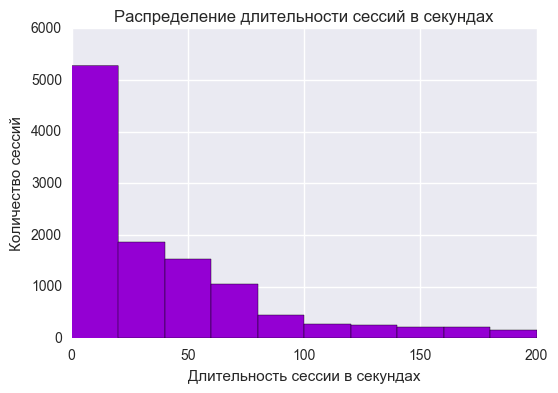

In [82]:
data = train_data_10users[train_data_10users['t_span'] <= 200]['t_span']
fig1 = data.hist(color='darkviolet')
fig1.set_title(u'Распределение длительности сессий в секундах')
fig1.set_xlabel(u'Длительность сессии в секундах')
fig1.set_ylabel(u'Количество сессий')
plt.show()

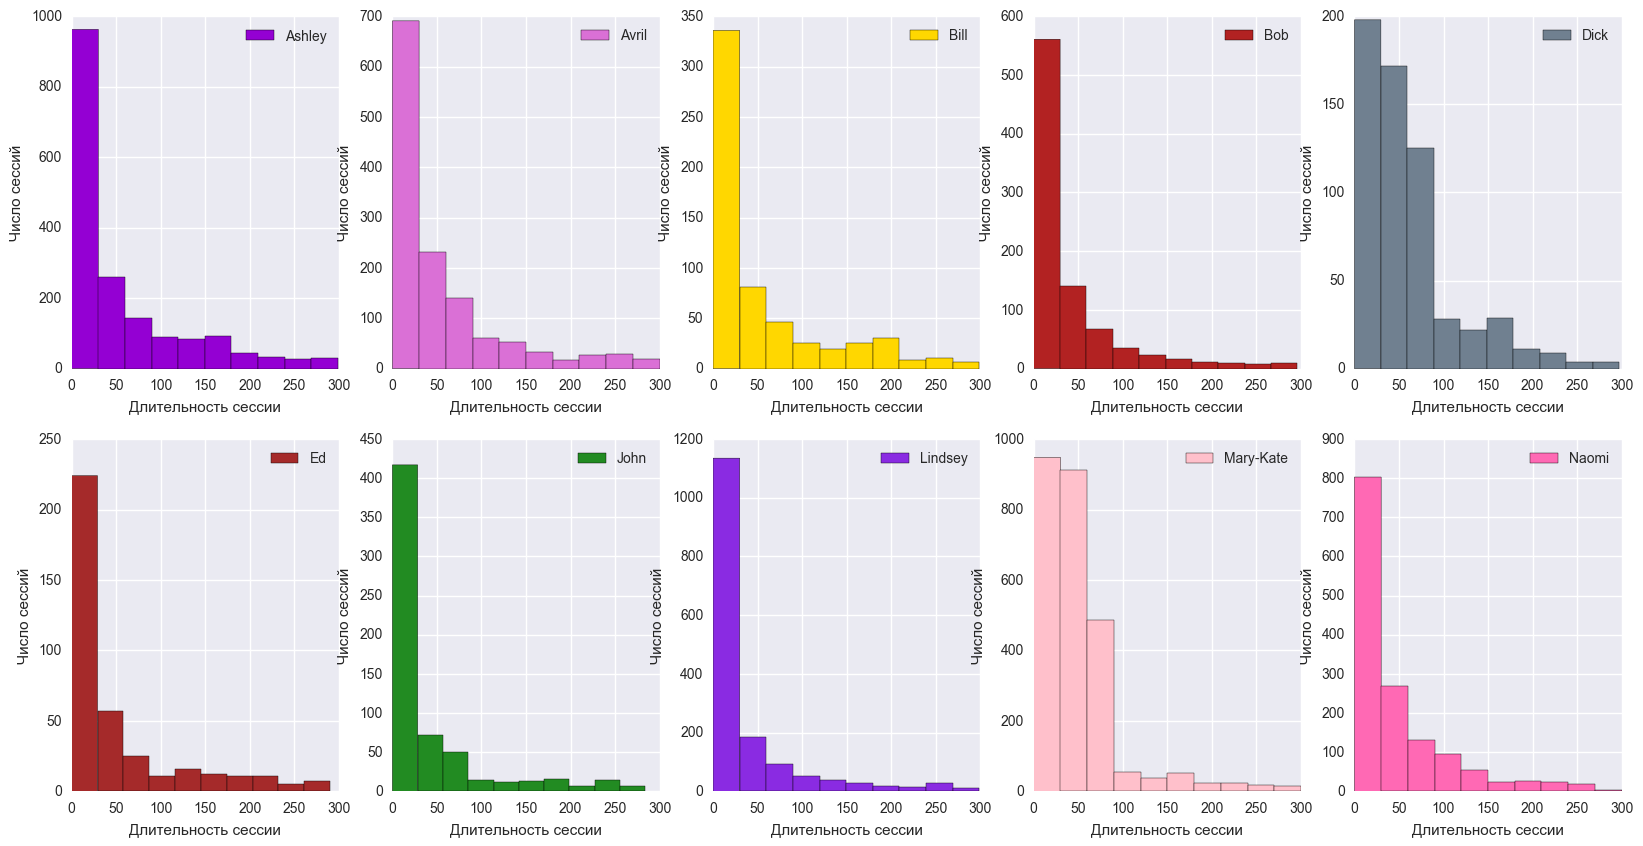

In [83]:
fig10, axes = plt.subplots(nrows=2, ncols=5, figsize=(20, 10))

for i, (user, d10) in  enumerate(pd.groupby(train_data_10users[train_data_10users['t_span'] <= 300], 'uid')):
    ax = axes[i//5, i%5]
    ax.set(xlabel=u'Длительность сессии', ylabel=u'Число сессий')
    hist = d10['t_span'].hist(color=color_dic[user], ax=ax)
    hist.legend([user])
plt.show()

**2. Постройте гистограмму распределения числа уникальных сайтов в сессии (*#unique_sites*). Сделайте гистограмму цвета *aqua*, подпишите оси по-русски.**

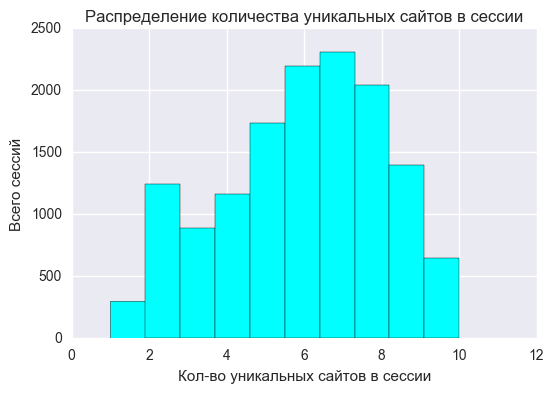

In [202]:
fig2 = train_data_10users["n_sites"].hist(color='aqua')
fig2.set_title(u'Распределение количества уникальных сайтов в сессии')
fig2.set_xlabel(u'Кол-во уникальных сайтов в сессии')
fig2.set_ylabel(u'Всего сессий')
plt.show()

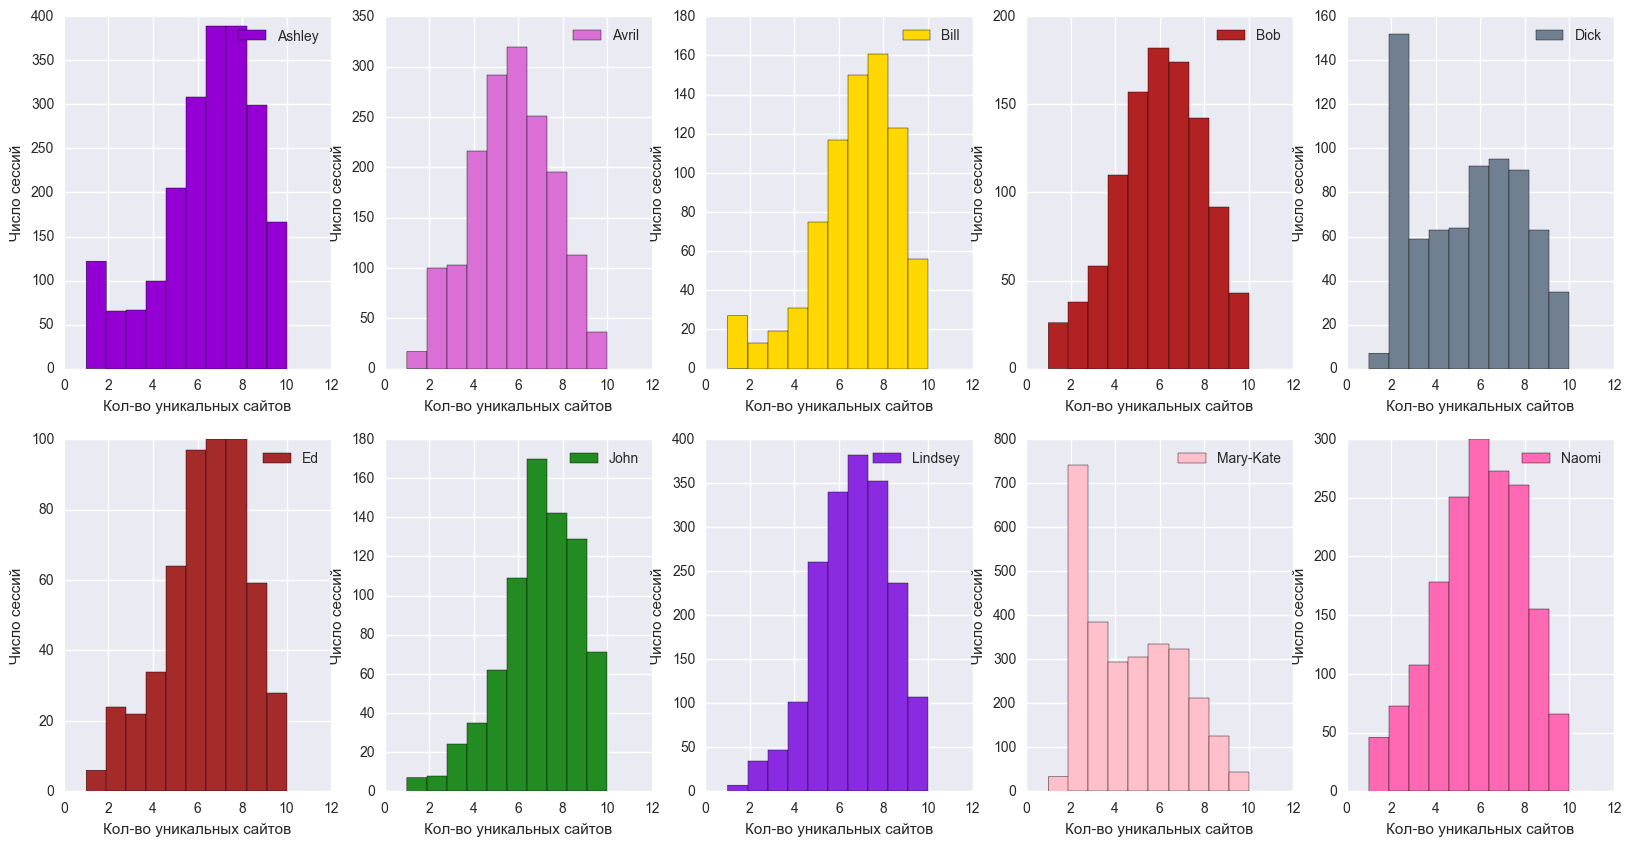

In [203]:
fig3, axes = plt.subplots(nrows=2, ncols=5, figsize=(20, 10))

for i, (user, df) in  enumerate(pd.groupby(train_data_10users, 'uid')):
    ax = axes[i//5, i%5]
    ax.set(xlabel=u'Кол-во уникальных сайтов', ylabel=u'Число сессий')
    hist = df['n_sites'].hist(color=color_dic[user], ax=ax)
    hist.legend([user])
plt.show()

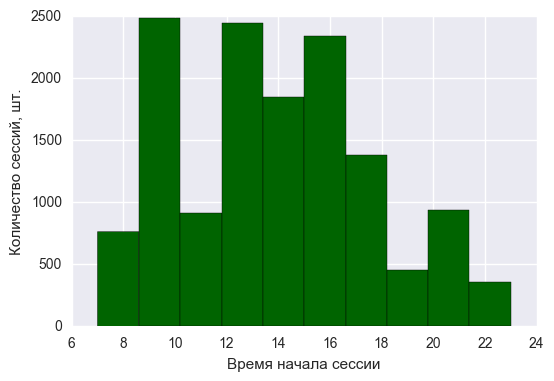

In [204]:
fig4 = train_data_10users['s_hour'].hist(color='darkgreen')
fig4.set(xlabel=u'Время начала сессии', ylabel=u'Количество сессий, шт.')
plt.show()

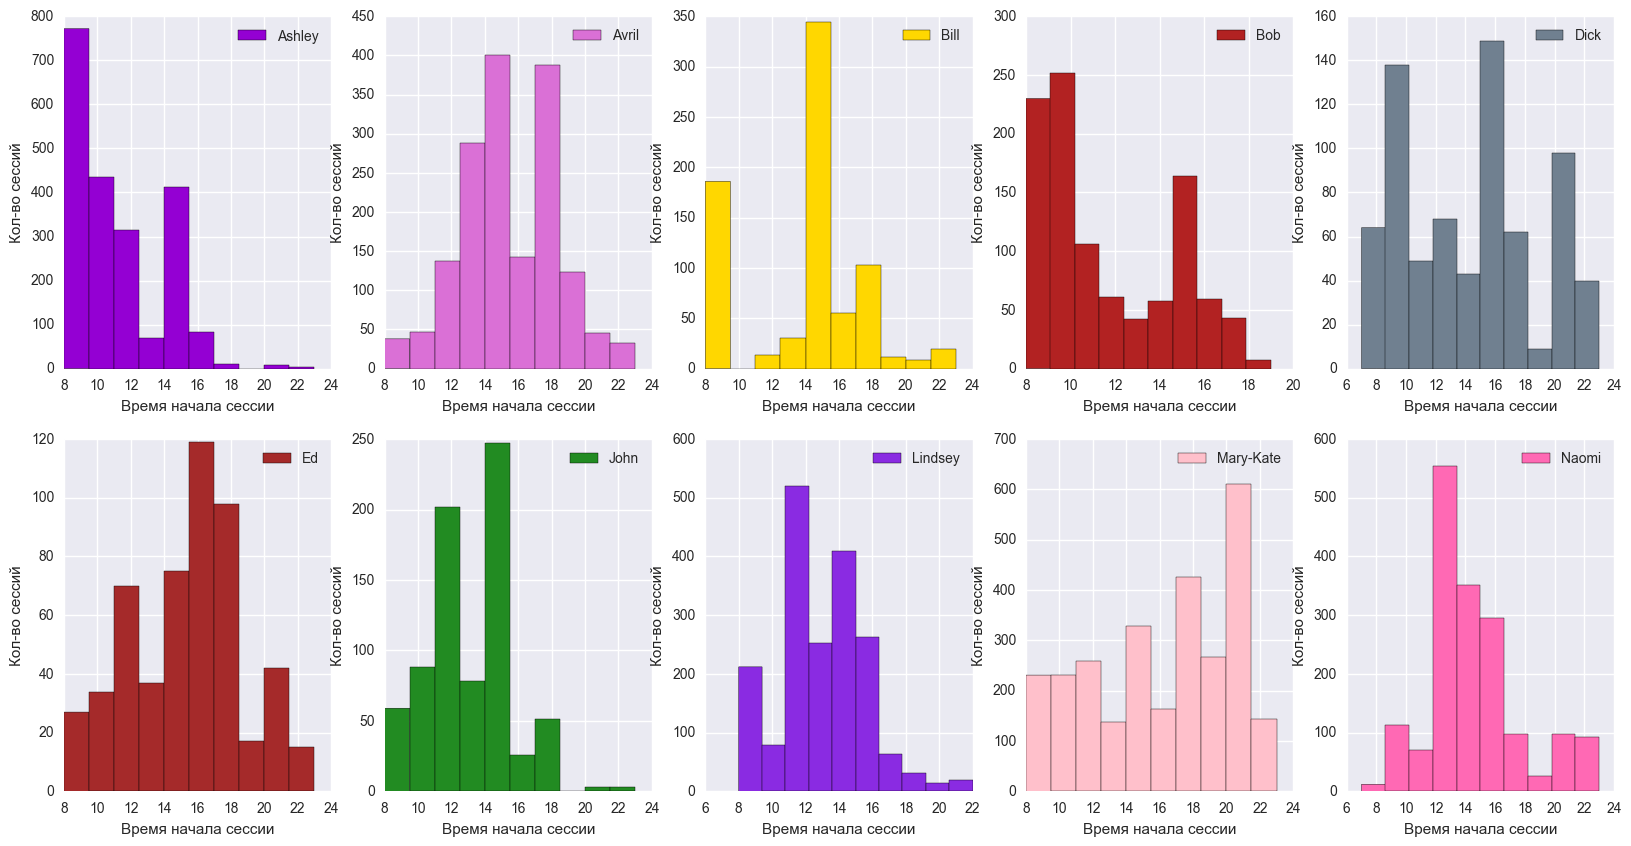

In [205]:
fig5, axes = plt.subplots(nrows=2, ncols=5, figsize=(20, 10))

for i, (user, df) in  enumerate(pd.groupby(train_data_10users, 'uid')): 
    ax = axes[i//5, i%5]
    ax.set(xlabel=u'Время начала сессии', ylabel=u'Кол-во сессий')
    hist = df['s_hour'].hist(color=color_dic[user],ax=ax)
    hist.legend([user])
plt.show()

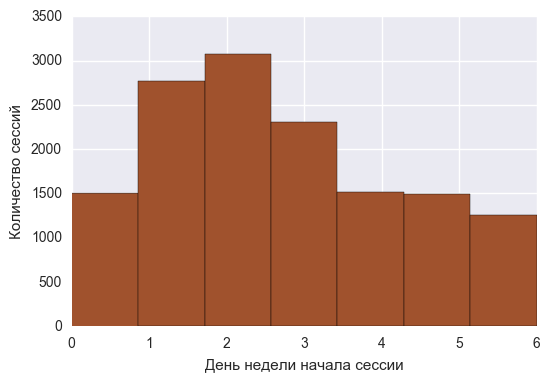

In [206]:
fig6 = train_data_10users['d_week'].hist(color='sienna',bins=7)
fig6.set(xlabel=u'День недели начала сессии', ylabel=u'Количество сессий')

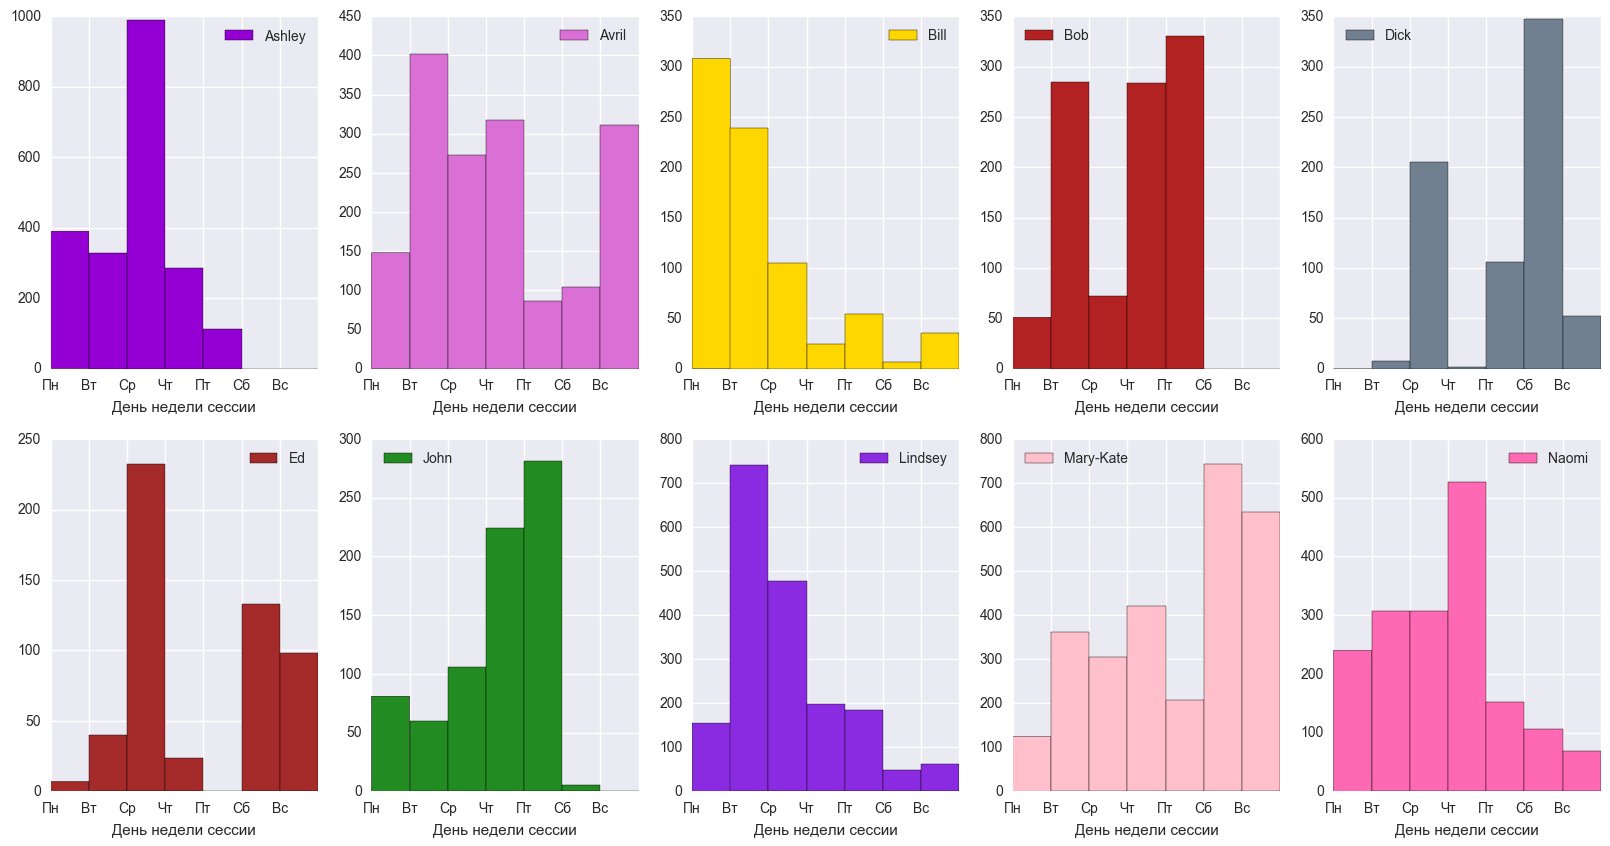

In [207]:
bins = [ 0, 1, 2, 3, 4, 5, 6, 7]
labels = [u'Пн', u'Вт', u'Ср', u'Чт', u'Пт', u'Сб', u'Вс']

fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(20, 10))

for i, (user, df) in  enumerate(pd.groupby(train_data_10users, 'uid')): 
    ax = axes[i//5, i%5]
    ax.set_xticklabels(labels, ha='center')
    ax.set_xlabel(u'День недели сессии')
    ax.hist(df['d_week'], color=color_dic[user], bins=bins)
    ax.legend([user], loc='best')


In [ ]:
Общие замечания:
    
1)	Число уникальных сайтов в сессии не дает четкой картины дифференциации пользователя

2)	Время начала сессии дает более четкую картину поведения пользователя 

3)	Дни недели работы в инете также имеют индивидуальные распределения

4)  Длительности сессий каждого пользователя распределены по Парето и имеют характерные признаки


Замечания по отдельным пользователям:
    
1)	Ashley – активен с 8 до 16, не заходит в выходные, чаще всего в ср

2)	Avril - активна с 8 до 23, чаще всего вт, ср, вс

3)	Bill – активен утром и днем до 18, с пн по ср

4)	Bob – активен с 8 до 17, не заходит в выходные

5)	Dick –  активен с 7 до 23, реже всего в пн

6)	Ed –  активен с 8 до 23, не работает в пят, чаще всего в ср и выходные

7)	John -  активен с 18 до 24, не работает в выходные

8)	Lindsey –  активен с 8 до 23, редко в выходные, чаще всего вт и ср

9)	Mary_Kate –  активна с 8-23, чаще всего выходные, реже всего пн

10)	Naomi активна весь день,  реже всего в выходные, чаще всего в чет


In [13]:
with open('capstone_websites_data/site_freq_10users.pkl','rb') as dict_freq_file:
    site_freq_10users = pickle.load(dict_freq_file)

In [14]:
top10_dict = sorted(site_freq_10users.items(), key=lambda x: x[1][1], reverse=True)[:10]
print (top10_dict)

[('s.youtube.com', (1, 8300)), ('www.google.fr', (2, 7813)), ('www.google.com', (3, 5441)), ('mail.google.com', (4, 4158)), ('www.facebook.com', (5, 4141)), ('apis.google.com', (6, 3758)), ('r3---sn-gxo5uxg-jqbe.googlevideo.com', (7, 3244)), ('r1---sn-gxo5uxg-jqbe.googlevideo.com', (8, 3094)), ('plus.google.com', (9, 2630)), ('accounts.google.com', (10, 2089))]


In [15]:
top10_sites = list()
top10_freqs = list()
for site in top10_dict:
    top10_sites.append(site[0])
    top10_freqs.append(site[1][1])

for s, f in zip(top10_sites, top10_freqs) :
    print(str(s) + " -> " + str(f)) 

s.youtube.com -> 8300
www.google.fr -> 7813
www.google.com -> 5441
mail.google.com -> 4158
www.facebook.com -> 4141
apis.google.com -> 3758
r3---sn-gxo5uxg-jqbe.googlevideo.com -> 3244
r1---sn-gxo5uxg-jqbe.googlevideo.com -> 3094
plus.google.com -> 2630
accounts.google.com -> 2089


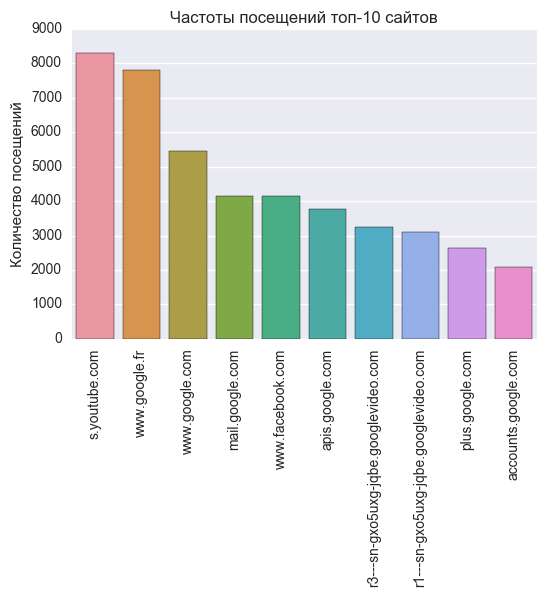

In [16]:
fig8=sns.barplot(top10_sites, top10_freqs)
fig8.set_xticklabels(top10_sites, rotation=90)

fig8.set_title(u'Частоты посещений топ-10 сайтов')
fig8.set_ylabel(u'Количество посещений')
plt.show()

In [ ]:
Предлагается рассмотреть 4 категорий новых признаков:
    
1) Работа в инете в конретные дни недели

2) Часы работы в инете в интервалах: ночь - (0,4), раннее утро - (5, 7), рабочее время - (8, 19), вечер - (20, 23)

3) Наличие в сессиях определенных сайтов, которые мы можем задать в ручную или выбрать случайно

4) Посещение груп сайтов: социальные сети, почта, и-покупки, технологии, карты и т.п. 

In [18]:
with open('capstone_websites_data/site_freq_10users.pkl','rb') as dict_freq_file:
    site_freq_10users = pickle.load(dict_freq_file)

In [19]:
# rebuild site dictionary to look name by id
id_site_dict = {i : name for name, (i, fr) in site_freq_10users.items()}

In [21]:
def feature_engineering(csv_files_mask, days_list, hours_intervals, sites_visited, groups_visited, session_length=10):
    
    def value_positions(mylist, myval) :
        if myval in mylist:
            return [i for i, x in enumerate(mylist) if x == myval]
        else :
            return None

    # array of source data
    with open(csv_files_mask, 'rb') as df_file:
        data = pickle.load(df_file)
    od = data.as_matrix()
    N, M = od.shape
    o_names = list(data.columns.values)
   
    # array for days statistics
    Ldl = len(days_list)
    dl = np.zeros(N*Ldl, dtype='int').reshape(N, Ldl )
    d_week_pos = M - 2
    d_names   = [('dr'+ str(x)) for x in range(Ldl)]
    
    # array for time statistics
    Lhi = len(hours_intervals)
    ti = np.zeros(N * Lhi, dtype='int').reshape(N, Lhi )
    s_hour_pos = M - 3
    h_names = [('hr'+ str(x)) for x in range(Lhi)]
    
    # array for site statistics
    Lsv = len(sites_visited)
    sl = np.zeros(N * Lsv, dtype='int').reshape(N, Lsv )
    s_names = [('sn'+ str(x)) for x in range(Lsv)]
    
    # array for groups statistics
    Lgv = len(groups_visited)
    gl = np.zeros(N * Lgv, dtype='int').reshape(N, Lgv )
    g_names = [('gr'+ str(x)) for x in range(Lgv)]
     
    # calculate all statistics
    for i in range(N):
        for k, days in enumerate(days_list) : # check if day days-ranage
            if days[0] <= od[i, d_week_pos] <= days[1] : 
                dl[i, k] = 1 
                break       # hours intervals do not intersect
                
        for k, intvl in enumerate(hours_intervals) :
            if intvl[0] <= od[i, s_hour_pos] <= intvl[1] :  # check hour in range 
                ti[i, k] = 1
                break       # hours intervals do not intersect
                
        for k, sid in enumerate(sites_visited) :
            if sid in od[i, :session_length] :
                sl[i, k] += list(od[i, :session_length]).count(sid)  # count number of times visited
                
        for k, group in enumerate(groups_visited) :
            for sid in group[1] :
                if sid in od[i, :session_length] :
                    gl[i, k] += list(od[i, :session_length]).count(sid) # count number of times visited

    od = np.hstack((od, dl) )
    od = np.hstack((od, ti) )
    od = np.hstack((od, sl) )
    od = np.hstack((od, gl) )
    
    new_feature_names = d_names + h_names + s_names + g_names
    return pd.DataFrame(od, columns= o_names + new_feature_names), d_names, h_names, s_names, g_names

In [22]:
super_features_3users, s1_names, s2_names, s3_names, s4_names = feature_engineering(
    'new_features_3users.pkl', [(1,2), (3,4) ], [(12,18)], [4,2,6], [('social', [1,2,9] )], session_length=10
    )

In [23]:
super_features_3users # [s1_names+s2_names+s3_names]

,s1,s2,s3,s4,s5,s6,s7,s8,s9,s10,dif2,dif3,...,t_span,n_sites,s_hour,d_week,uid,dr0,dr1,hr0,sn0,sn1,sn2,gr0
0,4,2,2,9,2,1,7,5,11,8,287,1184,...,7998,8,9,4,1,0,1,0,1,3,0,5
1,4,1,1,1,0,0,0,0,0,0,2,3,...,60,2,12,4,1,0,1,1,1,0,0,3
2,4,2,6,6,2,0,0,0,0,0,287,1184,...,7935,3,9,4,2,0,1,0,1,2,2,2
3,3,1,2,1,2,1,1,5,10,3,287,1184,...,7998,5,9,4,3,0,1,0,0,2,0,6
4,3,1,2,0,0,0,0,0,0,0,287,1184,...,1471,3,12,4,3,0,1,1,0,1,0,2


In [26]:
top_dict = sorted(site_freq_10users.items(), key=lambda x: x[1][1], reverse=True)[:200]

In [35]:
print (top_dict)

[('s.youtube.com', (1, 8300)), ('www.google.fr', (2, 7813)), ('www.google.com', (3, 5441)), ('mail.google.com', (4, 4158)), ('www.facebook.com', (5, 4141)), ('apis.google.com', (6, 3758)), ('r3---sn-gxo5uxg-jqbe.googlevideo.com', (7, 3244)), ('r1---sn-gxo5uxg-jqbe.googlevideo.com', (8, 3094)), ('plus.google.com', (9, 2630)), ('accounts.google.com', (10, 2089)), ('r2---sn-gxo5uxg-jqbe.googlevideo.com', (11, 1939)), ('fr-mg42.mail.yahoo.com', (12, 1868)), ('www.youtube.com', (13, 1804)), ('r4---sn-gxo5uxg-jqbe.googlevideo.com', (14, 1702)), ('clients1.google.com', (15, 1493)), ('download.jboss.org', (16, 1441)), ('s-static.ak.facebook.com', (17, 1388)), ('static.ak.facebook.com', (18, 1265)), ('i1.ytimg.com', (19, 1232)), ('twitter.com', (20, 1204)), ('accounts.youtube.com', (21, 1057)), ('platform.twitter.com', (22, 1041)), ('clients6.google.com', (23, 1039)), ('safebrowsing-cache.google.com', (24, 1039)), ('translate.google.fr', (25, 1002)), ('api.twitter.com', (26, 982)), ('accounts.g

In [28]:
def print_sites(site_list, key_word) :
    for site in site_list :
        if (key_word in site[0]) :
            print (site)

In [29]:
print_sites(top_dict, 'mail')

('mail.google.com', (4, 4158))
('fr-mg42.mail.yahoo.com', (12, 1868))
('chatenabled.mail.google.com', (33, 676))
('webmail.laposte.net', (55, 399))
('ycpi-mail-rest-core4.msg.yahoo.com', (57, 367))
('bay178.mail.live.com', (70, 288))
('ir2-attach.mail.yahoo.com', (110, 154))
('b.mail.google.com', (115, 141))
('fr.mail.yahoo.com', (137, 116))
('mg.mail.yahoo.com', (142, 115))
('dub125.mail.live.com', (152, 110))
('dub116.mail.live.com', (162, 103))
('mail.live.com', (165, 101))
('dub114.mail.live.com', (167, 99))


In [30]:
print_sites(top_dict, 'facebook')

('www.facebook.com', (5, 4141))
('s-static.ak.facebook.com', (17, 1388))
('static.ak.facebook.com', (18, 1265))
('connect.facebook.net', (45, 482))


In [31]:
print_sites(top_dict, 'linkedin')

('www.linkedin.com', (53, 407))
('platform.linkedin.com', (130, 123))


In [33]:
print_sites(top_dict, 'laposte')

('webmail.laposte.net', (55, 399))
('www.laposte.net', (134, 119))


In [36]:
print_sites(top_dict, 'thawte')

('ocsp.thawte.com', (80, 257))


In [37]:
print_sites(top_dict, 'verisign')

('ocsp.verisign.com', (85, 239))
('evsecure-ocsp.verisign.com', (107, 161))
('evintl-ocsp.verisign.com', (184, 91))


In [38]:
print_sites(top_dict, 'truste')

('choices.truste.com', (170, 98))


In [42]:
print_sites(top_dict, 'games-workshop')

('www.games-workshop.com', (183, 92))


In [43]:
print_sites(top_dict, 'stackoverflow.com')

('stackoverflow.com', (175, 96))


In [44]:
print_sites(top_dict, 'showroomprive')

('www.showroomprive.com', (158, 105))
('as.showroomprive.com', (180, 93))


In [72]:
day_features = [(5, 6)] # выходные

time_features = [(5,7), (20,23)]  # в какое время суток,  (рабочее и ночное время исключаем)

site_features = [125, 151, 166, 170, 175, 183, 187, 190  ]  # individual site ids

group_features = list([ # ('facebook', [5, 17, 18, 45]),
                        # ('linkedin', [53, 130]),
                       ('google mail', [4, 33, 115]), 
                       ('yahoo mail', [12, 57, 110, 137, 142]), 
                       ('live mail', [70, 152, 162, 165, 167]), 
                       ('laposte', [55, 134] ), 
                       ('showroomprive', [158, 180] ), 
                       ('verisign', [85, 107, 184] )
                      ])

In [65]:
%%time
super_features_10users, s1_names, s2_names, s3_names, s4_names = feature_engineering('new_features_10users.pkl', 
                                              day_features, time_features, site_features, group_features, session_length=10)

Wall time: 863 ms


In [61]:
super_features_10users[s1_names+s2_names+s3_names+s4_names].sample(3)

,dr0,hr0,hr1,sn0,sn1,sn2,sn3,sn4,sn5,sn6,sn7,gr0,gr1,gr2,gr3,gr4,gr5
115,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2660,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9296,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [218]:
%%time
super_features_150users, _, _, _ = feature_engineering('new_features_150users.pkl', 
                                              day_features, time_features, site_features, session_length=10)

Wall time: 3.11 s


In [219]:
super_features_150users[s1_names+s2_names+s3_names].sample(3)

,dr0,dr1,hr0,hr1,hr2,hr3,sn0,sn1,sn2,sn3,sn4,sn5,sn6,sn7,sn8
75646,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1
30605,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0
131225,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0


In [66]:
id_name_dict = {128: 'Mary-Kate', 39: 'Ashley', 207: 'Lindsey', 127: 'Naomi', 237: 'Avril',
               33: 'Bob', 50: 'Bill', 31: 'John', 100: 'Dick', 241: 'Ed'}
super_features_10users['uid'] = super_features_10users['uid'].map(id_name_dict)
color_dic = {'Mary-Kate': 'pink', 'Ashley': 'darkviolet', 'Lindsey':'blueviolet', 
             'Naomi': 'hotpink', 'Avril': 'orchid', 
             'Bob': 'firebrick', 'Bill': 'gold', 'John': 'forestgreen', 
             'Dick': 'slategrey', 'Ed':'brown'}

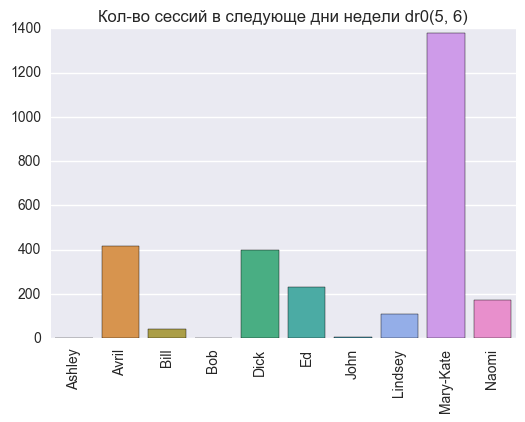

In [67]:
for f, feature in enumerate(s1_names):
    x = list()
    y = list()
    
    xlabels = list()
    for i, (user, d1) in  enumerate(pd.groupby(super_features_10users, 'uid')): 
        y.append( d1[feature].values.sum() )
        x.append(i)
        xlabels.append(user)
        
    fig01=sns.barplot(x, y)
    fig01.set_xticklabels(xlabels, rotation=90)
    fig01.set_title(u'Кол-во сессий в следующе дни недели ' + feature + str(day_features[f]))

    plt.show()

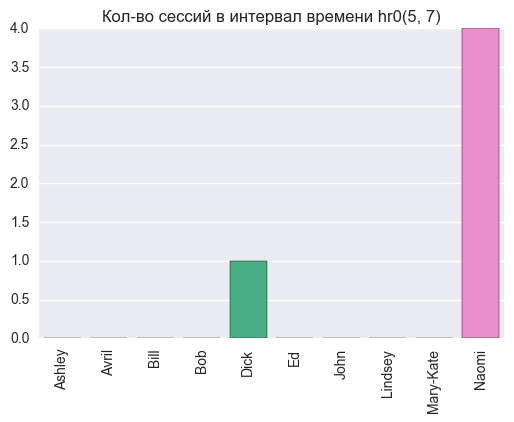

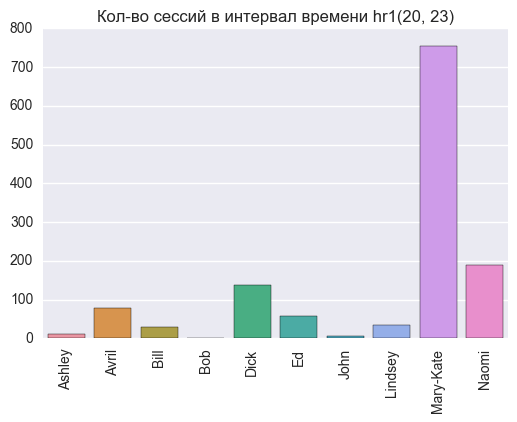

In [68]:
for f, feature in enumerate(s2_names):
    x = list()
    y = list()
    xlabels = list()
    for i, (user, d2) in  enumerate(pd.groupby(super_features_10users, 'uid')): 
        y.append( d2[feature].values.sum() )
        x.append(i)
        xlabels.append(user)
        
    fig02=sns.barplot(x, y)
    fig02.set_xticklabels(xlabels, rotation=90)
    fig02.set_title(u'Кол-во сессий в интервал времени ' + feature + str(time_features[f]))

    plt.show()

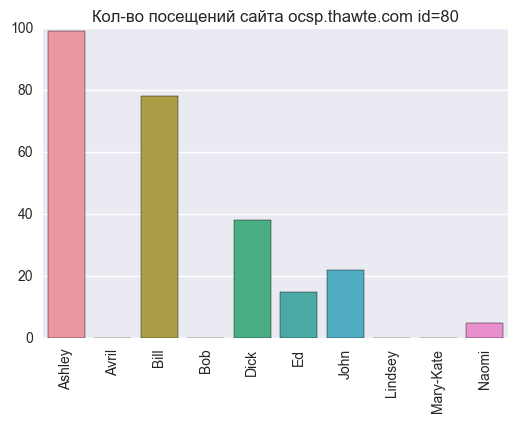

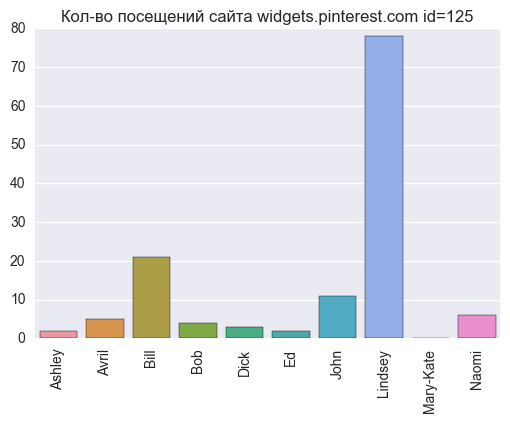

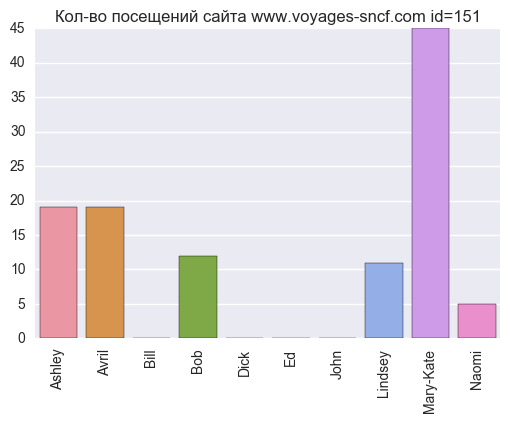

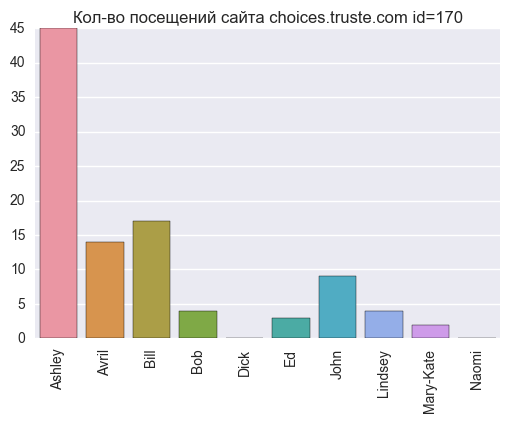

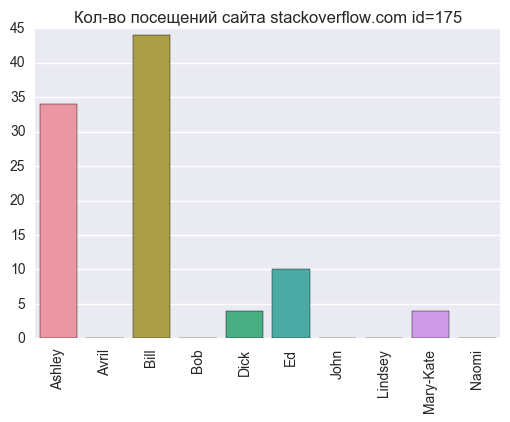

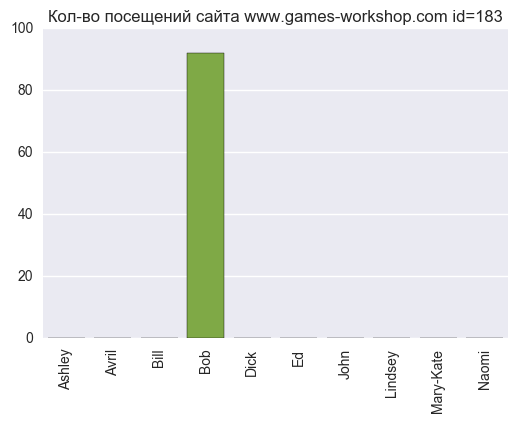

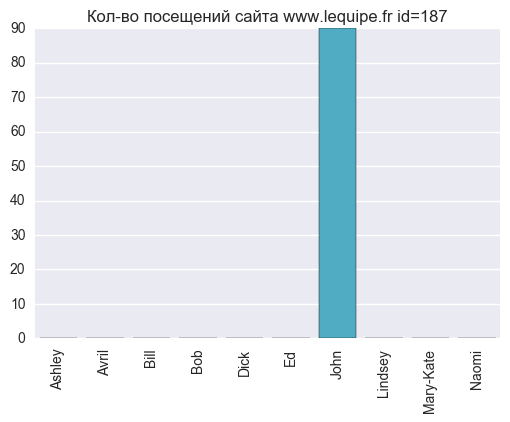

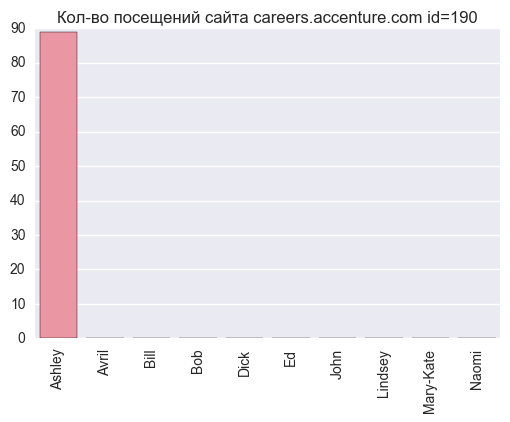

In [69]:
for f, feature in enumerate(s3_names):
    x = list()
    y = list()
    xlabels = list()
    for i, (user, d3) in  enumerate(pd.groupby(super_features_10users, 'uid')): 
        y.append( d3[feature].values.sum() )
        x.append(i)
        xlabels.append(user)
        
    fig03=sns.barplot(x, y)
    fig03.set_xticklabels(xlabels, rotation=90)
    fig03.set_title(u'Кол-во посещений сайта ' + str(id_site_dict.get(site_features[f]) + " id=" + str(site_features[f]) ) )

    plt.show()

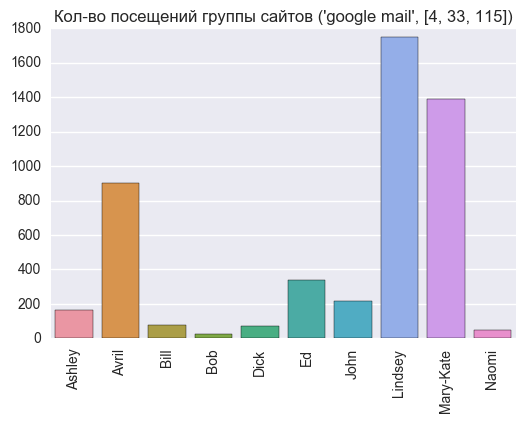

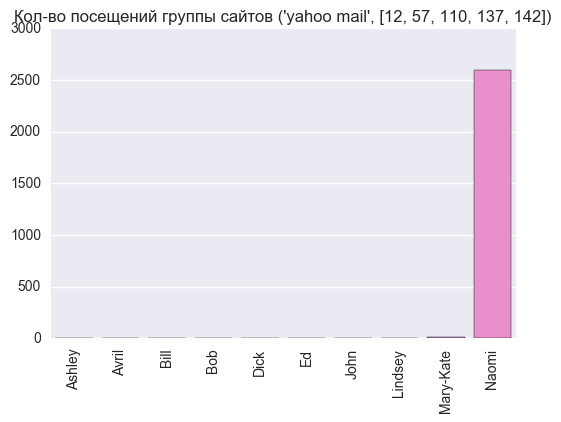

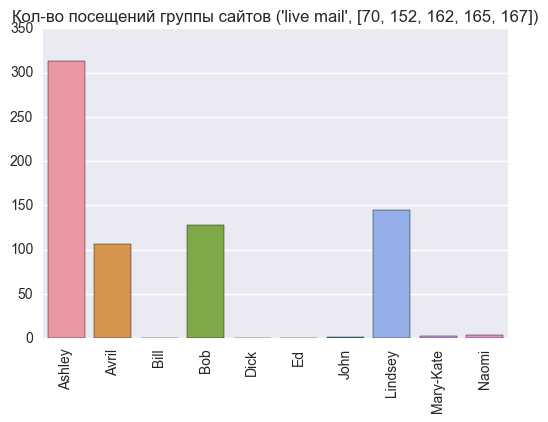

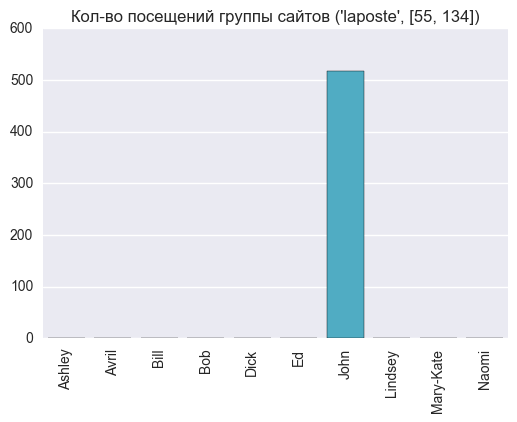

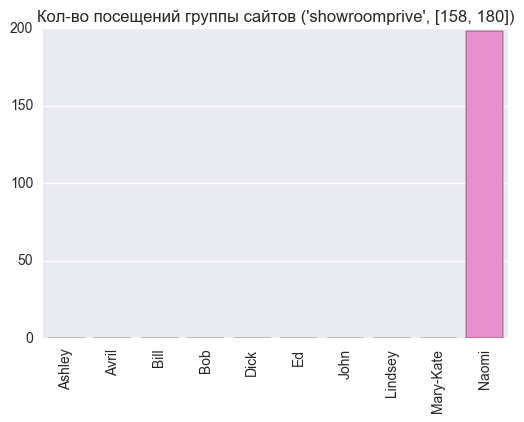

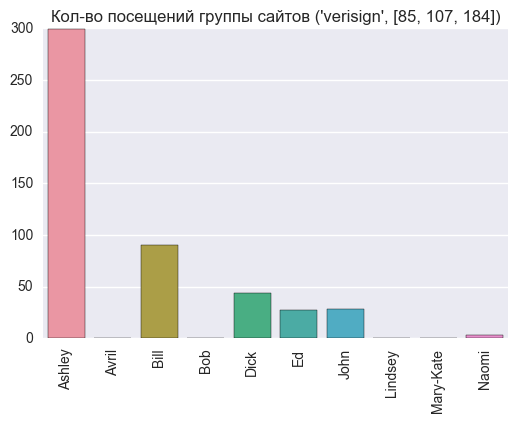

In [70]:
for f, feature in enumerate(s4_names):
    x = list()
    y = list()
    xlabels = list()
    for i, (user, d4) in  enumerate(pd.groupby(super_features_10users, 'uid')): 
        y.append( d4[feature].values.sum() )
        x.append(i)
        xlabels.append(user)
        
    fig04=sns.barplot(x, y)
    fig04.set_xticklabels(xlabels, rotation=90)
    fig04.set_title(u'Кол-во посещений группы сайтов ' + str(group_features[f]) )

    plt.show()

In [54]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, n_iter=500, random_state=7)

In [71]:
%%time
tsne_res = tsne.fit_transform(super_features_10users[s1_names + s2_names + s3_names+s4_names].values)

Wall time: 4min 22s


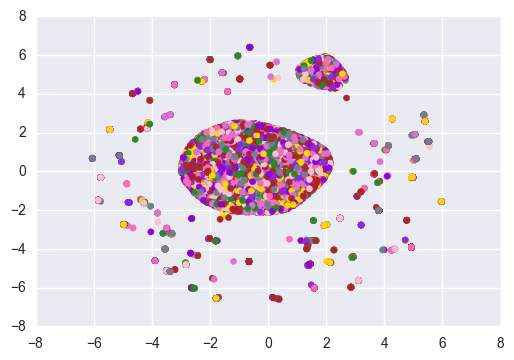

In [73]:
colors = ['pink', 'darkviolet', 'blueviolet', 'hotpink', 'orchid', 'firebrick', 'gold', 'forestgreen','slategrey', 'brown']
plt.scatter(tsne_res[:, 0], tsne_res[:, 1], color=colors) 

In [93]:
import random
random_sites_40 = random.sample(range(100, 200), 40)
random_sites_30 = random.sample(range(100, 200), 30)
random_sites_20 = random.sample(range(100, 200), 20)

In [94]:
colors = ['pink', 'darkviolet', 'blueviolet', 'hotpink', 'orchid', 'firebrick', 'gold', 'forestgreen','slategrey', 'brown']

In [76]:
%%time
print (random_sites_40)
super_features_10users, s1_names, s2_names, s3_names, s4_names = feature_engineering('new_features_10users.pkl', 
                                              day_features, time_features, random_sites_40, group_features, session_length=10)
tsne_40 = tsne.fit_transform(super_features_10users[s1_names + s2_names + s3_names + s4_names].values)

Wall time: 5min 54s


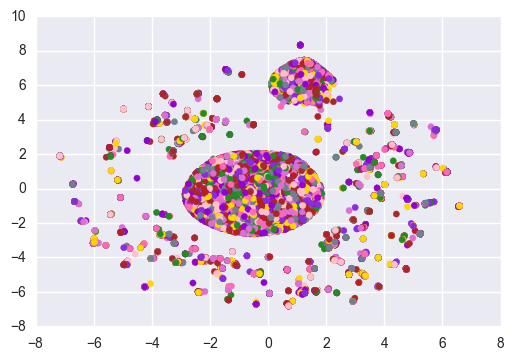

In [77]:
plt.scatter(tsne_40[:, 0], tsne_40[:, 1], color=colors) 

In [85]:
%%time
print (random_sites_30)
super_features_10users, s1_names, s2_names, s3_names, s4_names = feature_engineering('new_features_10users.pkl', 
                                              day_features, time_features, random_sites_30, group_features, session_length=10)
tsne_30 = tsne.fit_transform(super_features_10users[s1_names + s2_names + s3_names + s4_names].values)

[140, 152, 108, 156, 186, 147, 121, 191, 143, 106, 189, 190, 137, 188, 157, 161, 125, 173, 133, 187]
Wall time: 4min 40s


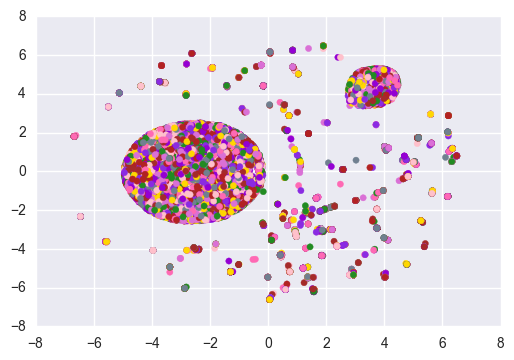

In [88]:
plt.scatter(tsne_30[:, 0], tsne_30[:, 1], color=colors) 

In [95]:
%%time
print (random_sites_20)

super_features_10users, s1_names, s2_names, s3_names, s4_names = feature_engineering('new_features_10users.pkl', 
                                              day_features, time_features, random_sites_20, group_features, session_length=10)

tsne_20 = tsne.fit_transform(super_features_10users[s1_names + s2_names + s3_names + s4_names].values)

[193, 146, 168, 107, 166, 186, 102, 198, 106, 151, 113, 140, 188, 130, 144, 121, 101, 135, 170, 104]
Wall time: 5min


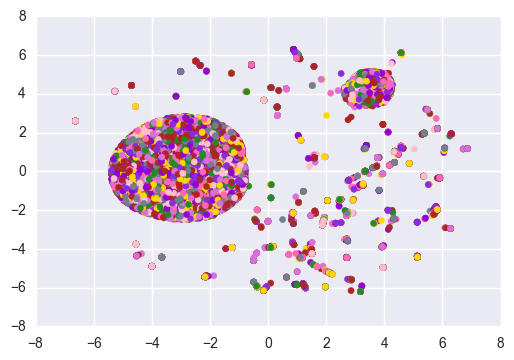

In [96]:
plt.scatter(tsne_20[:, 0], tsne_20[:, 1], color=colors) 

Выводы: 
    
    1) целенаправленный или случайный выбор сайтов не дают существенно различных результатов, будем задавать случайно
    
    2) карты и социальные сети используют все - нет смысла использовать
    
    3) в рабочее время все используют инет - нет смысла использовать этот интервал
    
    4) обычно пользователи используют одну почтовую службу - эти критерии можно использовать
    
    5) рано утром не все используют инет- критерий можно оставить
    
    6) по выходным не все используют инет - критерий можно оставить

In [ ]:
# selected features – among (session_timespan, ..., day_of_week) and your own new ones
with open('selected_features_10users.pkl', 'wb') as selected_features_10users_pkl:
    pickle.dump(selected_features_10users, selected_features_10users_pkl)
with open('selected_features_150users.pkl', 'wb') as selected_features_150users_pkl:
    pickle.dump(selected_features_150users, selected_features_150users_pkl)